In [1]:
# pip install pandahouse  # если библиотека ещё не установлена

# connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      # 'database':'default',
                      # 'user':'student', 
                      # 'password':'dpo_python_2020'}
# connection_test = dict(database='test',
                  # host='http://clickhouse.beslan.pro:8080',
                  # user='student-rw',
                  # password='656e2b0c9c')
            
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandahouse as ph
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'}
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT COUNT(*)
    FROM 
        {db}.ldn_listings 

    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


In [2]:
# Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

# price – цена за ночь
# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

# Пример результирующей таблицы:

# +-----------------+------------+
# | room_type       | price      |
# +-----------------+------------+
# | Private room    |         65 | 
# | Entire home/apt |        100 | 
# +-----------------+------------+
# Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

# В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

w = '''
    SELECT
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price,
    room_type
    FROM 
        {db}.ldn_listings
    ORDER BY id
    LIMIT 1000
    '''
w_test = ph.read_clickhouse(query=w, connection=connection_default)
quantile_table = w_test.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()
quantile_table
# Альтернатива: answer = w_test.query('room_type == "Private room"').quantile(q = 0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


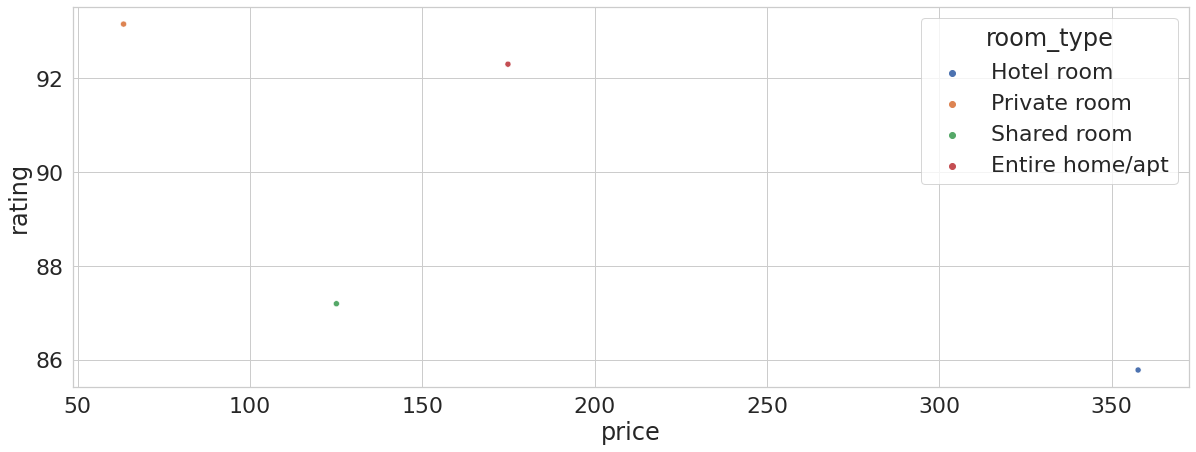

In [3]:
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating).
# В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

# Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

# Исходная таблица должна выглядеть так:

# +-----------------+------------+--------------------+
# | room_type       | price      |review_scores_rating|
# +-----------------+------------+--------------------+
# | Private room    |         65 | 96.0               |
# | Entire home/apt |        100 | 78.0               |
# +-----------------+------------+--------------------+
# 1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

# 2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y)
# c разбивкой по типу жилья (параметр hue)

e = '''
    SELECT
    room_type,
    AVG(toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' ))) AS price,
    AVG(toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '' ))) AS rating
    FROM 
        {db}.ldn_listings
    GROUP BY room_type
    LIMIT 100
    '''
e_test = ph.read_clickhouse(query=e, connection=connection_default)
sns.scatterplot(data = e_test, x = 'price', y = 'rating', hue = 'room_type')

In [34]:
# Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

# Проверим, какие способы верификации аккаунта использовали хозяева,
# предлагающие различные впечатления (experiences_offered != 'none').
# Для каждого уникального пользователя выгрузите только две колонки:

# host_id – идентификатор хозяина (уникальный)
# host_verifications – какими способами хост подтвердил свой профиль
# Затем обработайте столбец host_verifications:

# В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])).
# Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
# "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


# 2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

# Сколько хозяев подтвердили профиль с помощью аккаунта Google?

u = """
SELECT
    DISTINCT host_id,
    host_verifications
    
    FROM ldn_listings
WHERE experiences_offered != 'none'
ORDER BY id
    
"""
u_test = ph.read_clickhouse(query = u, connection=connection_default)
u_test["host_verifications"] = u_test.host_verifications.apply(lambda x: x.strip('[]').split(","))
u_test["host_verifications"].explode("host_verifications").value_counts().count

<bound method Series.count of  'phone'                    1345
'email'                     1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
 'manual_online'              16
'phone'                       16
 'sent_id'                     6
Name: host_verifications, dtype: int64>

In [33]:
u_test

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


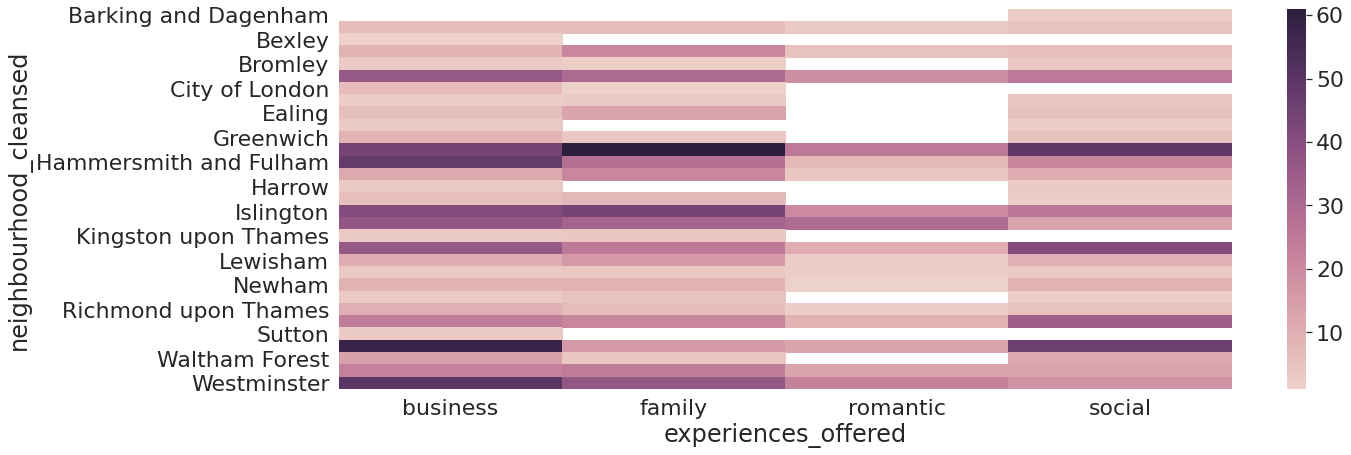

In [4]:
# Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.
# Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

# Пример трёх строк результирующей таблицы:
# в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

# +------------------------+---------------------+-------------------+
# | neighbourhood_cleansed | experiences_offered | experiences_count |
# +------------------------+---------------------+-------------------+
# | City of London         | business            |                 7 |
# | City of London         | family              |                 1 |
# | City of London         | romantic            |                 1 |
# +------------------------+---------------------+-------------------+
# Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк.
# Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления,
# а значения – число объявлений с таким впечатлением для каждого района.
# Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).

r = ''' 
    SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(id) AS experiences_count
    FROM
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''
r_test = ph.read_clickhouse(query=r, connection=connection_default)

df = r_test \
    .pivot(index = 'neighbourhood_cleansed', \
           columns = 'experiences_offered', \
           values = 'experiences_count')
sns.heatmap(df, cmap=sns.cubehelix_palette(as_cmap=True))

In [5]:
df.head(5)

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


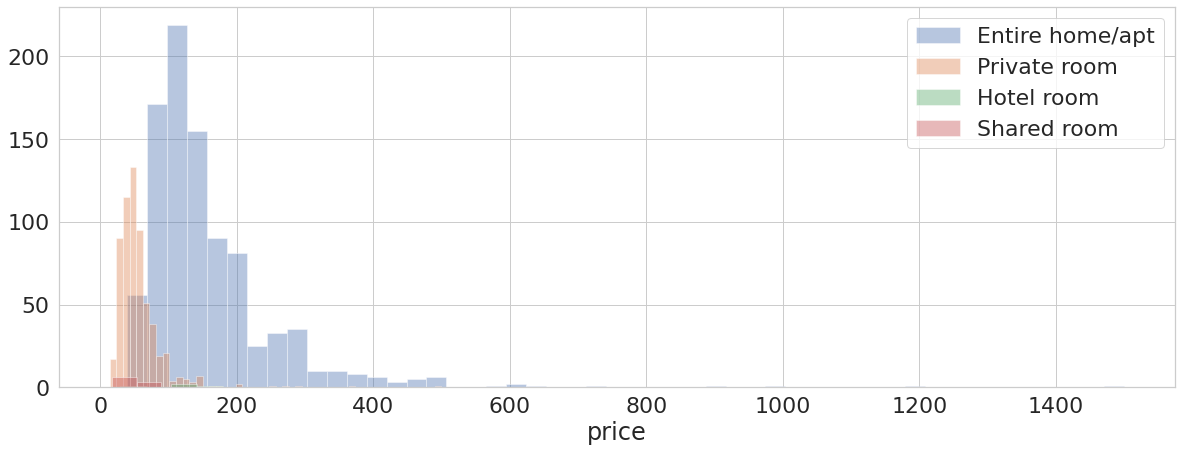

No handles with labels found to put in legend.


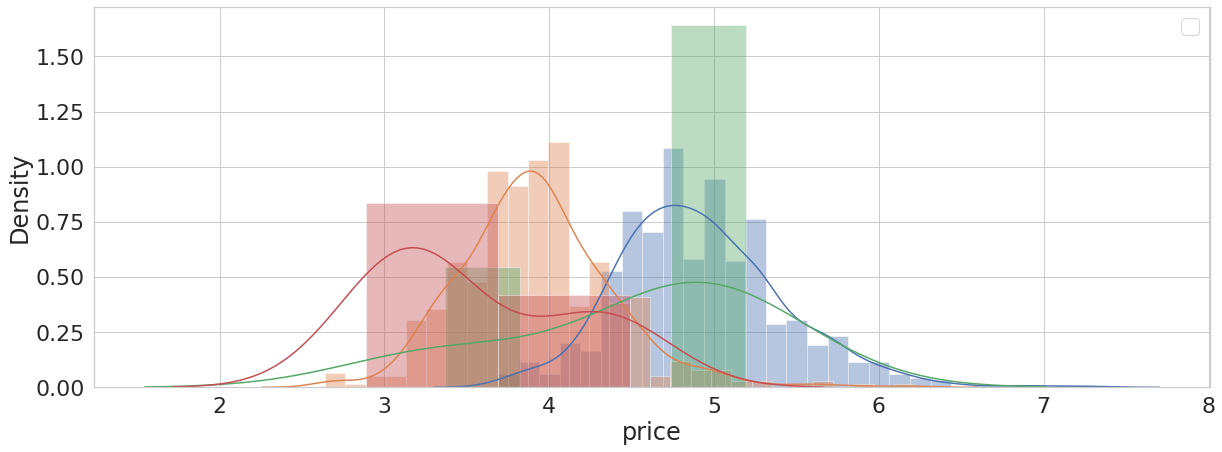

In [6]:
# Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.
# Необходимые для составления запроса столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь 
# experiences_offered – вид доступного впечатления (оставить не 'none')
# Пример части результирующей таблицы:

# +-----------------+------------+
# | room_type       | price_corr |
# +-----------------+------------+
# | Private room    |         65 |
# | Entire home/apt |        100 |
# | Entire home/apt |        ... |
# +-----------------+------------+

# Далее постройте два графика, используя distplot из библиотеки seaborn:

# На первом отобразите исходные распределения цен для каждого типа жилья
# На втором – логарифмированные значения (np.log())

t = ''' 
    SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price
    FROM
        {db}.ldn_listings
    WHERE experiences_offered != 'none'
    ORDER BY price DESC
    '''
t_test = ph.read_clickhouse(query=t, connection=connection_default)

sns.distplot(t_test.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(t_test.query("room_type == 'Private room'").price, kde=False, label='Private room')
sns.distplot(t_test.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(t_test.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.legend()
plt.show()

sns.distplot(np.log(t_test.query("room_type == 'Entire home/apt'").price))
sns.distplot(np.log(t_test.query("room_type == 'Private room'").price))
sns.distplot(np.log(t_test.query("room_type == 'Hotel room'").price))
sns.distplot(np.log(t_test.query("room_type == 'Shared room'").price))
plt.legend()
plt.show()

In [7]:
t_test.head(5)

,room_type,price
0,Entire home/apt,1500.0
1,Entire home/apt,1200.0
2,Entire home/apt,999.0
3,Entire home/apt,901.0
4,Entire home/apt,735.0


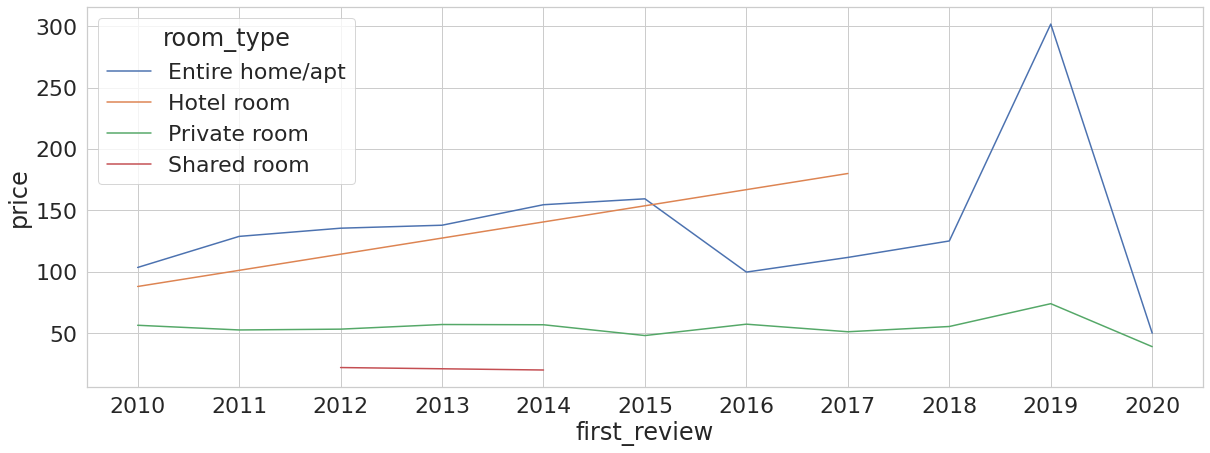

In [14]:
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь
# first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
# Ограничение поставьте на 1000 строк.

# Пример результирующей таблицы:

# +-----------------+------------+------------+
# | room_type       | price_corr |first_review|
# +-----------------+------------+------------+
# | Private room    |         65 | 2010-03-23 |
# | Entire home/apt |        100 | 2012-01-01 |
# +-----------------+------------+------------+
# Используя библиотеку seaborn и функцию lineplot,
# постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue')
# по годам (ось X). Датафрейм должен быть отсортирован по годам.

# Пример датафрейма, который будет служить основой для графика:

# +-----------------+------------+------------+
# | room_type       | avg_price  | year       |
# +-----------------+------------+------------+
# | Private room    |         54 | 2010       |
# | Entire home/apt |        168 | 2012       |
# +-----------------+------------+------------+
# Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например,
# с помощью применения lambda-функции.

# toDate(first_review) AS date_review
y = ''' 
    SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price,
    first_review
    FROM
        {db}.ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''
y_test = ph.read_clickhouse(query=y, connection=connection_default)
y_test['first_review'] = y_test.first_review.apply(lambda x: x[:4])
dq_8 = y_test \
    .groupby(['room_type', 'first_review'], as_index=False) \
    .agg({'price' :'mean'})
sns.lineplot(dq_8["first_review"], dq_8["price"], hue=dq_8["room_type"])

In [13]:
y_test

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012
